In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)


I'm using:  cuda
I'm using:  cuda


## A non-linear ODE

$
\begin{cases}
    \displaystyle -\frac{d}{dx}\Big[(1+u^2)\frac{du}{dx}\Big] = -2\pi\cos(\pi x)^2\sin(\pi x) +  \pi^2 \sin(\pi x)\big(\sin(\pi x)^2 +1\big), \quad x \in (0,1) \\[15pt] 
    u = 0, \ x=0,1
\end{cases}$



$u = \sin(\pi x)\\$

In [2]:
def convert(x):
  return x.cpu().detach().numpy()

def L2_err(y,y_pred):
  return np.linalg.norm(y-y_pred,2)

Define the the FNN with 5 layer, 20 neuron and tanh (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as activation function

In [3]:
input = 1
output = 1
hidden_layer = 5*[20]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function,input,hidden_layer,output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-4): 4 x Linear(in_features=20, out_features=20, bias=True)
  )
  (output): Linear(in_features=20, out_features=1, bias=False)
)

Using torch.rand define the points that will be used for training. For the test use torch.linspace


In [4]:
x0 = torch.Tensor([0]).to(device)
x1 = torch.Tensor([2]).to(device)
u_b0 = torch.Tensor([0]).to(device)
u_b1 = torch.Tensor([0]).to(device)

n_train_points = 200 
n_test_points  = 500

x_train = 2*torch.rand([n_train_points, 1])
x_sort_train,_ = torch.sort(x_train,0)
x_test  = torch.linspace(0,2,n_test_points).unsqueeze(1)

Visualize the data

Text(0.5, 1.0, 'Collocation Points')

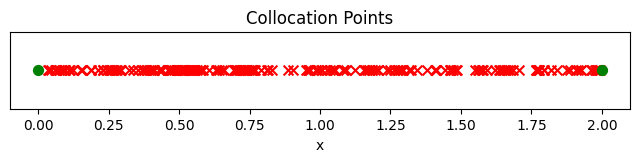

In [5]:
%matplotlib inline
plt.figure(figsize=(8, 1))  
plt.scatter(convert(x_train), np.zeros_like(convert(x_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(x0), np.zeros_like(convert(x0)), color='green', s=50, label='Collocation Points')
plt.scatter(convert(x1), np.zeros_like(convert(x1)), color='green', s=50, label='Collocation Points')
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')

Exact solution and rhs

In [6]:
def rhs(x):
    return  - 2*torch.pi**2*torch.cos(torch.pi*x)**2*torch.sin(torch.pi*x) + torch.pi**2*torch.sin(torch.pi*x)*(torch.sin(torch.pi*x)**2 + 1)
def exact_sol(x):
    return np.sin(np.pi*convert(x)) 

In [7]:
rhs_train = rhs(x_train)
u_exact_train = exact_sol(x_train)
rhs_train_sort = rhs(x_sort_train)
u_exact_train_sort = exact_sol(x_sort_train)

rhs_test = rhs(x_test)
u_exact_test = exact_sol(x_test)

Definition of the loss function for the training, where the metric will be define later some examples can be https://pytorch.org/docs/stable/nn.html#loss-functions

In [8]:
def eval_loss_ode(NN,x,rhs,metric):
    NN_x = torch.autograd.grad(NN.sum(),x,create_graph=True,retain_graph=True)[0]
    NN_x = (1+NN*NN)*NN_x
    NN_xx = torch.autograd.grad(NN_x.sum(),x,create_graph=True)[0]
    return metric(-NN_xx,rhs)

def eval_loss_IC(NN_0,y_0):
    return (NN_0 - y_0).pow(2).squeeze()

Training of the network, where the optimzer from here https://pytorch.org/docs/stable/optim.html

In [9]:
n_epochs = 5000
learining_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(),learining_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,50,0.96)

loss_values = np.empty([n_epochs+1,4]); #total,ode, b0,b1
MSE =  torch.nn.MSELoss()
STEP = 100#save every 100 epochs

assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1,2])
u_animate =  np.empty([int(n_epochs/STEP)+1,n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1,n_train_points])
k   = 0 

for epoch in range(n_epochs+1):
    x_train.requires_grad_(True) 
    u_NN     = FNN(x_train)
    loss_ode = eval_loss_ode(u_NN,x_train,rhs_train,MSE)
    
    u_NN_b0    = FNN(x0)
    loss_b0 = eval_loss_IC(u_NN_b0,u_b0)
    u_NN_b1    = FNN(x1)
    loss_b1 = eval_loss_IC(u_NN_b1,u_b1)

    loss = loss_ode + loss_b0 +loss_b1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_b0),convert(loss_b1)])

    if epoch%STEP == 0:
      lr = np.array(scheduler.get_last_lr())
      u_NN_test =  FNN(x_test)
      err[k,:] = [L2_err(convert(u_NN),u_exact_train), L2_err(convert(u_NN_test),u_exact_test)]
      u_animate[k,:]  = convert(FNN(x_sort_train).squeeze())
      err_animate[k,:]= (np.abs(u_animate[k,:] - u_exact_train_sort.squeeze()))
      print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e}  || Error  Train {err[k,0]:.2e} || Error Test  {err[k,1]:.2e}''\n'
            f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss b0 {loss_values[epoch,2]:.2e} || loss b1 {loss_values[epoch,3]:.2e}','\n')
      k+=1

Epoch 0 || learning rate 1.00e-03  || Error  Train 1.39e+01 || Error Test  1.86e+01
Global loss 1.20e+02 || loss ode 1.20e+02 || loss b0 2.51e-01 || loss b1 3.21e-01 

Epoch 100 || learning rate 9.22e-04  || Error  Train 1.87e+01 || Error Test  3.09e+01
Global loss 3.44e+01 || loss ode 3.23e+01 || loss b0 1.58e+00 || loss b1 4.29e-01 

Epoch 200 || learning rate 8.49e-04  || Error  Train 2.20e+01 || Error Test  3.53e+01
Global loss 9.76e+00 || loss ode 4.75e+00 || loss b0 4.99e+00 || loss b1 1.92e-02 

Epoch 300 || learning rate 7.83e-04  || Error  Train 1.46e+01 || Error Test  2.30e+01
Global loss 3.73e+00 || loss ode 7.02e-01 || loss b0 3.02e+00 || loss b1 6.46e-03 

Epoch 400 || learning rate 7.21e-04  || Error  Train 5.46e+00 || Error Test  8.59e+00
Global loss 1.20e+00 || loss ode 4.95e-01 || loss b0 6.74e-01 || loss b1 2.70e-02 

Epoch 500 || learning rate 6.65e-04  || Error  Train 4.49e-01 || Error Test  7.45e-01
Global loss 4.83e-02 || loss ode 4.66e-02 || loss b0 3.03e-06 || l

# Visualization of the results
Value of the loss function at the vary of the epochs

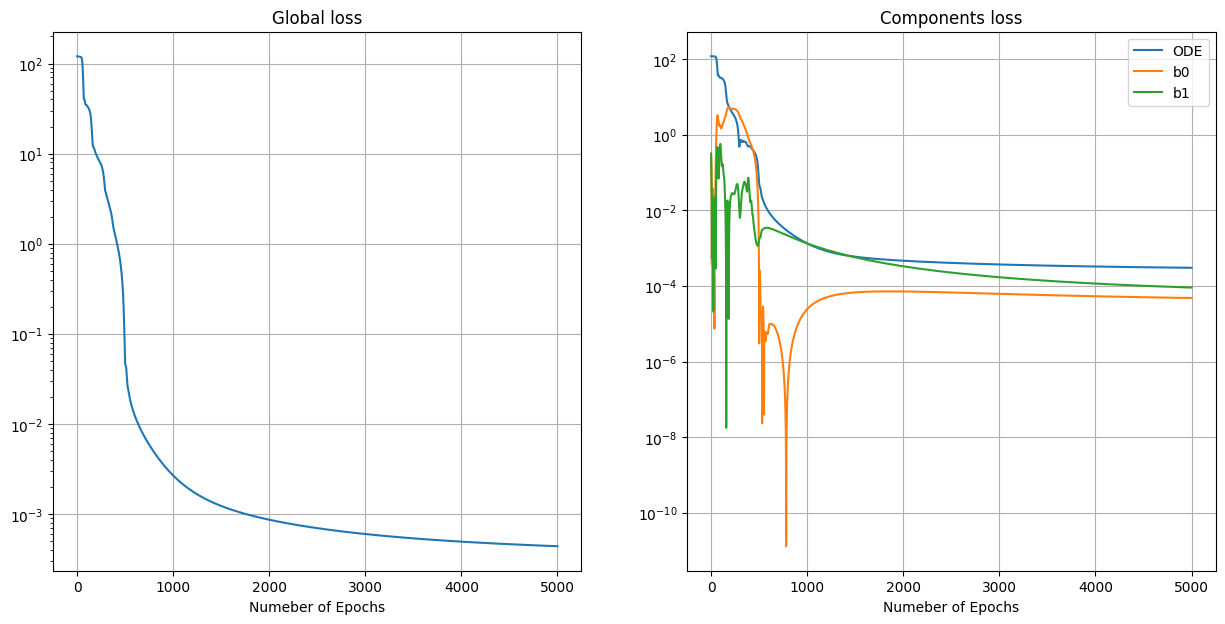

In [10]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'b0' )
axs[1].semilogy(epochs,loss_values[:,3],label = 'b1' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

Compare the exact solution with the PINN prediction and evaluate the point-wise error

In [11]:
x_test = convert(x_test)
u_NN_test = convert(u_NN_test)
x_sort_train = convert(x_sort_train)

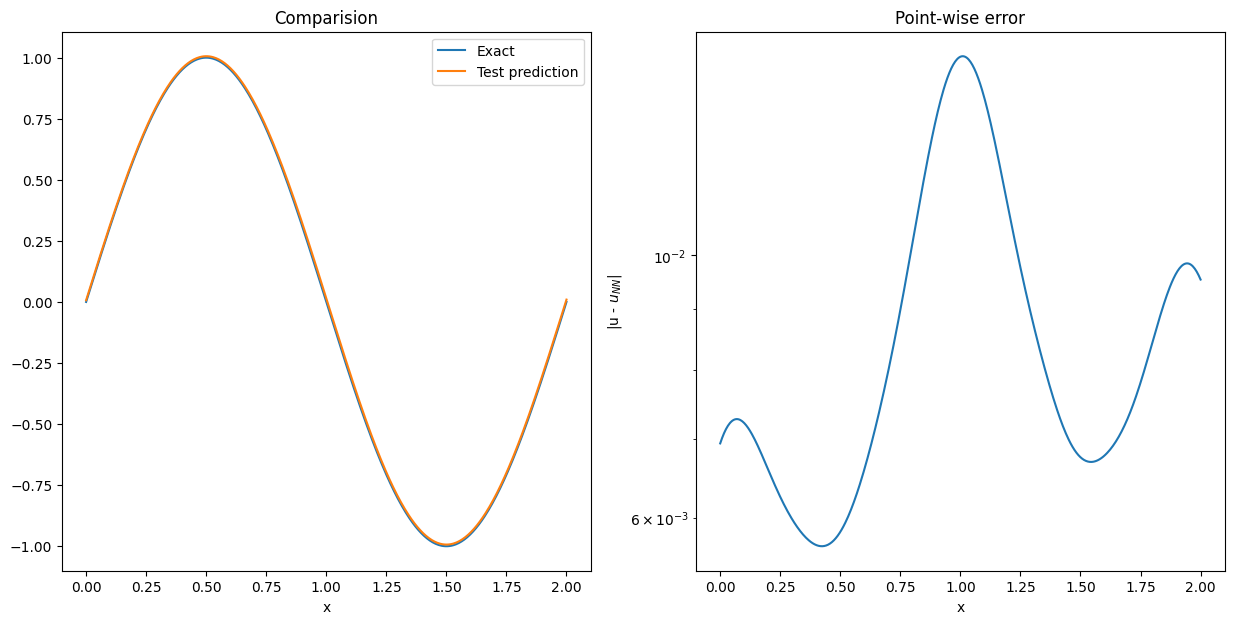

In [12]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(x_test,u_exact_test,label = 'Exact')
axs[0].plot(x_test,u_NN_test, label = 'Test prediction')
axs[0].set_xlabel('x')
axs[0].legend()
axs[0].set_title('Comparision')

axs[1].semilogy(x_test,np.abs(u_exact_test-u_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|u - $u_{NN}$|')
plt.show()

$L^2$ Errors

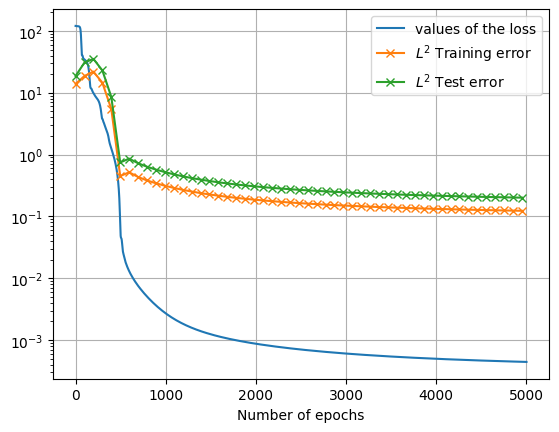

In [13]:
epochs = range(n_epochs+1)
y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

plt.semilogy(epochs,loss_values[:,0],label = 'values of the loss')
plt.semilogy(epochs[0:-1:STEP-1],err[:,0],'-x', label = '$L^2$ Training error')
plt.semilogy(epochs[0:-1:STEP-1],err[:,1],'-x', label = '$L^2$ Test error')

plt.xlabel('Number of epochs')
plt.grid('on')
plt.legend()
plt.show()

Animation of the solution and of the point wise error during training

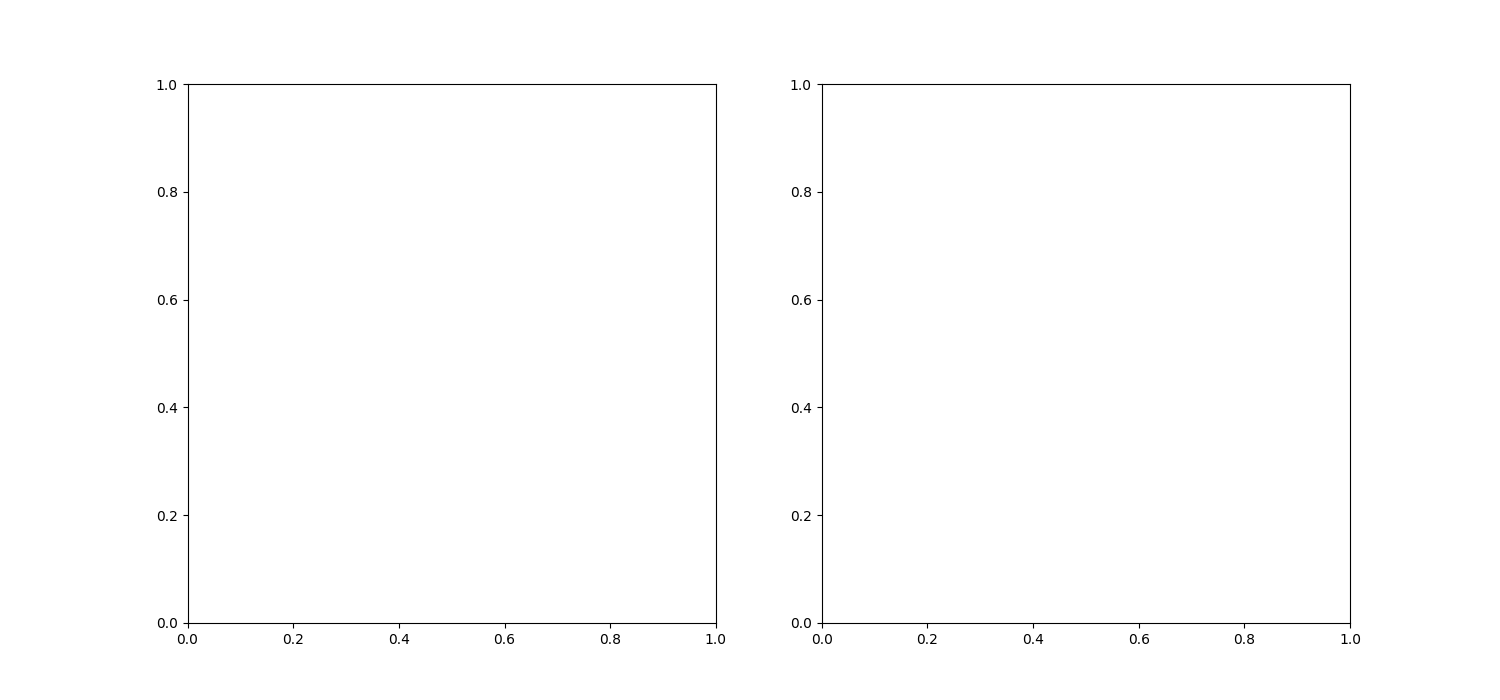

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1,2, figsize = (15,7),num = 3)

def updata_data(frame):
    axs[0].clear()
    axs[0].plot(x_sort_train,u_animate[frame,:],'b--',label = r'$y_{\Theta}$')
    axs[0].plot(x_sort_train,u_exact_train_sort,'r', label = 'Exact')
    axs[0].set_ylim([-np.max(u_animate),np.max(u_animate)])
    axs[0].set_xlim([0,2])
    axs[0].set_xlabel('t')

    axs[0].grid('on')
    axs[0].legend()

    axs[1].clear()
    axs[1].semilogy(x_sort_train,err_animate[frame,:])
    axs[1].grid('on')
    axs[1].set_ylim([np.min(err_animate)*0.9,np.max(err_animate)*1.1])
    axs[1].set_xlabel('t')
    axs[1].set_title(r'$|y - y_{\Theta}|$')
    plt.suptitle(f'Epoch {frame*STEP} || error {err[frame,0]:.2e}')
    return axs[0]

animation = FuncAnimation(fig,func = updata_data,frames=len(u_animate),interval = 500,)
plt.show()
#for google colab
#from IPython.display import HTML
#video = HTML(anim.to_html5_video())
#display(video)
#plt.close()